# On similarity measures for image registration
_María Camila Vásquez Correa_

## Necessary Packages
Some of these packages may seem known to you. The principal is pydicom, that will allow us to read a dicom image.

In [1]:
import numpy as np
import pydicom
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib
import skimage

### Reading dicom images
Here, I present two test images and how to read them. The function pixel_array extracts only the numpy array containing the value on each pixel

In [2]:
im_1 = pydicom.dcmread('im_1.dcm').pixel_array
im_2 = pydicom.dcmread('im_2.dcm').pixel_array

### Visualizing the images
Matplotlib pyplot is useful when showing images, however, is better to set some paramenters first

In [3]:
# Plot parameters
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

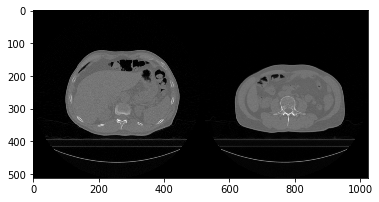

In [4]:
plt.imshow(np.hstack((im_1, im_2)))
plt.show()

### Reading NiFTi images
Some other examples are presented here. Remember that niFTi images contain more than one slice! The package nibabel is the most useful here. The function get data discards the metadata and leaves us only with the arrays of the images.

In [5]:
# Data loading
t1_img = nib.load('mni_icbm152_t1_tal_nlin_asym_09a.nii')
t1_data = t1_img.get_data()
t2_img = nib.load('mni_icbm152_t2_tal_nlin_asym_09a.nii')
t2_data = t2_img.get_data()

### Visualizing
Now, we will take one slice and see what do we got in our dataset!

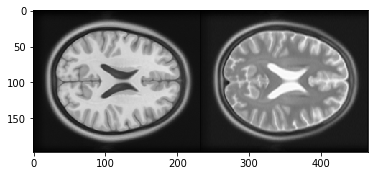

In [6]:
# Slice of the Nifti image
t1_slice = t1_data[:, :, 94]
t2_slice = t2_data[:, :, 94]
plt.imshow(np.hstack((t1_slice, t2_slice)))
plt.show()

Let's play! Any further questions?

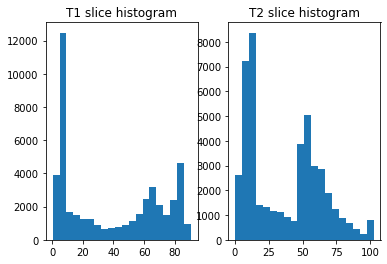

In [7]:
fig, axes = plt.subplots(1, 2)
axes[0].hist(t1_slice.ravel(), bins=20)
axes[0].set_title('T1 slice histogram')
axes[1].hist(t2_slice.ravel(), bins=20)
axes[1].set_title('T2 slice histogram')
plt.show()

0.78707985510953

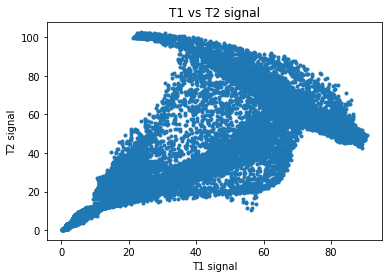

In [8]:
plt.plot(t1_slice.ravel(), t2_slice.ravel(), '.')
plt.xlabel('T1 signal')
plt.ylabel('T2 signal')
plt.title('T1 vs T2 signal')
np.corrcoef(t1_slice.ravel(), t2_slice.ravel())[0, 1]

Text(0.5, 1.0, 'T2 slice')

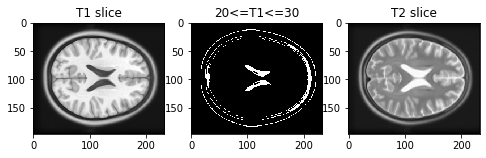

In [9]:
# Array that is True if T1 signal >= 20, <= 30, False otherwise
t1_20_30 = (t1_slice >= 20) & (t1_slice <= 30)
# Show T1 slice, mask for T1 between 20 and 30, T2 slice
fig, axes = plt.subplots(1, 3, figsize=(8, 3))
axes[0].imshow(t1_slice)
axes[0].set_title('T1 slice')
axes[1].imshow(t1_20_30)
axes[1].set_title('20<=T1<=30')
axes[2].imshow(t2_slice)
axes[2].set_title('T2 slice')

In [10]:
hist_2d, x_edges, y_edges = np.histogram2d(
    t1_slice.ravel(),
    t2_slice.ravel(),
    bins=20)

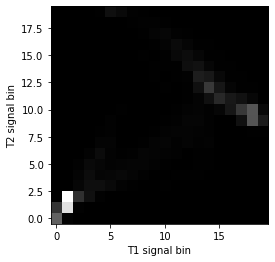

In [11]:
plt.imshow(hist_2d.T, origin='lower')
plt.xlabel('T1 signal bin')
plt.ylabel('T2 signal bin')
plt.show()

Text(0, 0.5, 'T2 signal bin')

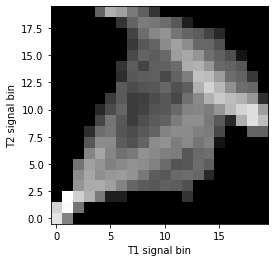

In [12]:
hist_2d_log = np.zeros(hist_2d.shape)
non_zeros = hist_2d != 0
hist_2d_log[non_zeros] = np.log(hist_2d[non_zeros])
plt.imshow(hist_2d_log.T, origin='lower')
plt.xlabel('T1 signal bin')
plt.ylabel('T2 signal bin')

## Mutual information

In [13]:
def mutual_information(hgram):
    """ Mutual information for joint histogram
    """
    # Convert bins counts to probability values
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

mutual_information(hist_2d)

1.3399511058289812

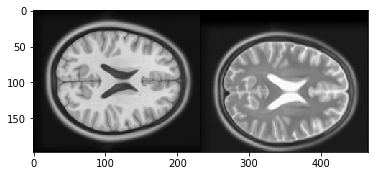

In [14]:
t2_slice_moved = np.zeros(t2_slice.shape)
t2_slice_moved[15:, :] = t2_slice[:-15, :]
plt.imshow(np.hstack((t1_slice, t2_slice_moved)))
plt.show()

In [15]:
def blur_image(Image_in, epsilon):
    Image = Image_in.copy()
    n = int(Image.size/epsilon)
    for i in range(1,n):
        b = [(Image <= epsilon*i) & (Image >= epsilon*(i-1))]
        Image[b] = 0.5*(epsilon*i + epsilon*(i-1))
    return Image

/home/camivasz/anaconda3/envs/practica/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


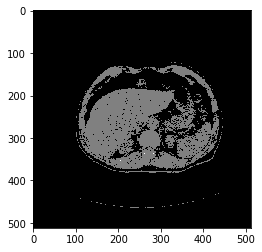

In [16]:
plt.imshow(blur_image(im_1, 1000))

/home/camivasz/anaconda3/envs/practica/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


KeyboardInterrupt: 

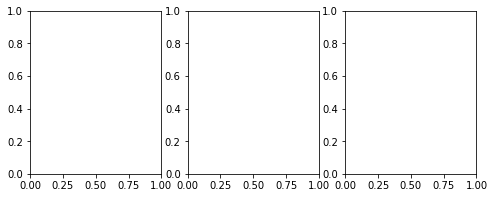

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3))
axes[0].imshow(blur_image(im_1, 1))
axes[0].set_title('epsilon = 1')
axes[1].imshow(blur_image(im_1, 100))
axes[1].set_title('epsilon = 100')
axes[2].imshow(blur_image(im_1, 1000))
axes[2].set_title('epsilon = 1000')
plt.show()

In [ ]:
t1_b = blur_image(t1_slice,1)
t2_b = blur_image(t2_slice,1)

In [ ]:
plt.plot(im_1.ravel(), im_2.ravel(), '.')
plt.xlabel('Image 1')
plt.ylabel('Image 2')
plt.title('Image 1 vs Image 2')
plt.show()

In [ ]:
hist_2d_moved, x_edges, y_edges = np.histogram2d(
    t1_slice.ravel(),
    t2_slice_moved.ravel(),
    bins=20)

In [ ]:
hist_2d_moved_log = np.zeros(hist_2d_moved.shape)
non_zeros = hist_2d_moved != 0
hist_2d_moved_log[non_zeros] = np.log(hist_2d_moved[non_zeros])
plt.imshow(hist_2d_moved_log.T, origin='lower')
plt.xlabel('T1 signal bin')
plt.ylabel('T2 signal bin')
plt.show()

In [ ]:
mutual_information(hist_2d_moved)

## Shannon Joint Entropy

In [ ]:
entropy_T1 = skimage.measure.shannon_entropy(t1_slice)
entropy_T2 = skimage.measure.shannon_entropy(t2_slice)
joint_entropy = entropy_T1 + entropy_T2 - mutual_information(hist_2d)

In [ ]:
joint_entropy

## Sum of squared differences

In [ ]:
def mse(imageA, imageB):
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	return err

In [ ]:
mse(t1_slice, t2_slice)

## Correlation coefficient

In [ ]:
def correlation_coefficient(patch1, patch2):
    product = np.mean((patch1 - patch1.mean()) * (patch2 - patch2.mean()))
    stds = patch1.std() * patch2.std()
    if stds == 0:
        return 0
    else:
        product /= stds
        return product

In [ ]:
correlation_coefficient(t1_slice, t2_slice)

## Correlation ratio

In [13]:
# Flat the vector
t1 = im_1.flatten()
t2 = im_2.flatten()

In [ ]:
plt.hist([t1,t2])
plt.show()

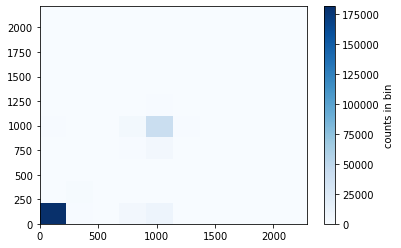

In [31]:
plt.hist2d(t1, t2, bins=10, cmap='Blues')
cb = plt.colorbar()
cb.set_label('counts in bin')

In [32]:
def CR(t1,t2,epsilon):
    # New data
    X = np.arange(epsilon*0.5, int(np.max(t1)),epsilon)
    Y = np.arange(epsilon*0.5, int(np.max(t2)),epsilon)
    def compress(AA,BB,epsilon):
        sx = len(X)
        sy = len(Y)
        a = np.zeros((sx, sy))
        for i in range(1,sx):
            for j in range(1,sy):
                b = [(AA <= epsilon*i) & (AA > epsilon*i-1) & (BB <= epsilon*j) & (BB > epsilon*j-1)]
                a[i,j] = np.sum(b)
        return a
    # Generation of the probability functions
    dens = compress(t1,t2,epsilon)
    marginal_x = np.sum(dens, axis = 1)
    marginal_y = np.sum(dens, axis = 0)
    def conditional_variance_x(y):
        py = marginal_y[int(y/epsilon + 0.5)-1]
        if py == 0:
            return 0
        else:
            left = X**2*dens[:,int(y/epsilon + 0.5)-1]/py
            right = X*dens[:,int(y/epsilon + 0.5)-1]/py
            return np.sum(left) - np.sum(right)**2
    def conditional_variance_y(x):
        px = marginal_x[int(x/epsilon + 0.5)-1]
        if px == 0:
            return 0
        else:
            left = Y**2*dens[int(x/epsilon + 0.5)-1,:]/px
            right = Y*dens[int(x/epsilon + 0.5)-1,:]/px
            return np.sum(left) - np.sum(right)**2
    var_x = np.var(X)
    su = 0
    for y in Y:
        su += conditional_variance_x(y)
    left = su/var_x
    var_y = np.var(Y)
    su = 0
    for x in X:
        su += conditional_variance_y(x)
    right = su/var_y
    return left + right

In [34]:
CR(t1,t2,1)

545.0880109778484

In [38]:
hist_2d_1, x_edges, y_edges = np.histogram2d(
    im_1.ravel(),
    im_1.ravel(),
    bins=20)
hist_2d_2, x_edges, y_edges = np.histogram2d(
    im_1.ravel(),
    im_2.ravel(),
    bins=20)

In [39]:
index = ["Correlation ratio", "Mutual information", "Correlation coefficient", "SSD", "Joint entropy"]
df = pd.DataFrame(index = index)

In [40]:
a = CR(im_1,im_2,100)
b = CR(im_1,im_1,100)
c = mutual_information(hist_2d_1)
d = mutual_information(hist_2d_2)
e = correlation_coefficient(im_1, im_2)
f = correlation_coefficient(im_1, im_1)
g = mse(im_1,im_2)
h = mse(im_1,im_1)
entropy_1 = skimage.measure.shannon_entropy(im_1)
entropy_2 = skimage.measure.shannon_entropy(im_1)
i = entropy_1 + entropy_2 - c
j = entropy_1 + entropy_1 - d

In [41]:
df["X = Y"] = [b,d,f,h,j]
df["X != Y"] = [a,c,e,g,i]

In [42]:
print(df.to_latex())

\begin{tabular}{lrr}
\toprule
{} &      X = Y &        X != Y \\
\midrule
Correlation ratio       &   0.000000 &      0.029895 \\
Mutual information      &   0.422443 &      1.132413 \\
Correlation coefficient &   1.000000 &      0.830312 \\
SSD                     &   0.000000 &  68382.666519 \\
Joint entropy           &  11.989594 &     11.279624 \\
\bottomrule
\end{tabular}



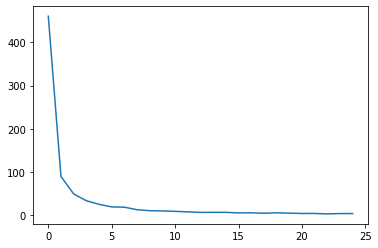

In [37]:
plt.plot([CR(t1,t2,x) for x in np.linspace(0.1,10,25)])
plt.show()

In [43]:
import plotly.offline as py
import plotly.graph_objects as go
py.init_notebook_mode(connected=True)

In [46]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=np.linspace(10,200,70), y=data,
                         line=dict(color='firebrick', width=4)))

# Edit the layout
fig.update_layout(title='Correlation ratio by blurring parameter',
                   xaxis_title='Correlation ratio',
                   yaxis_title='Blurring',
                plot_bgcolor='white')
fig.show()

In [45]:
from tqdm import tqdm

In [44]:
data = [CR(t1,t2,x) for x in np.linspace(10,200,70)]

## Estimation of the joint probability function
With copulas!

*Necessary packages*

In [14]:
import seaborn as sns
from scipy import stats

Let's start by sampling uniformly distributed values between 0 and 1

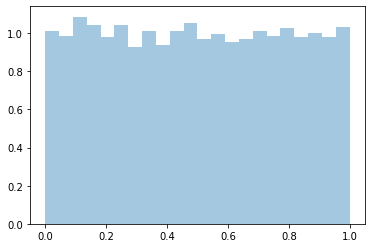

In [15]:
x = stats.uniform(0, 1).rvs(10000)
sns.distplot(x, kde=False, norm_hist=True);

Now, we will transform the distribution so the samples are now normally distributed

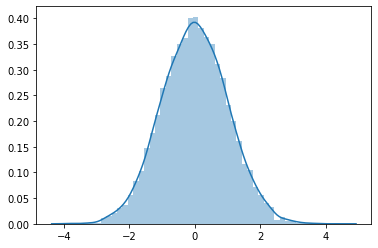

In [16]:
norm = stats.distributions.norm()
x_trans = norm.ppf(x)
sns.distplot(x_trans);

Plotting them together gives an intuiton about how the inverse CDF looks like

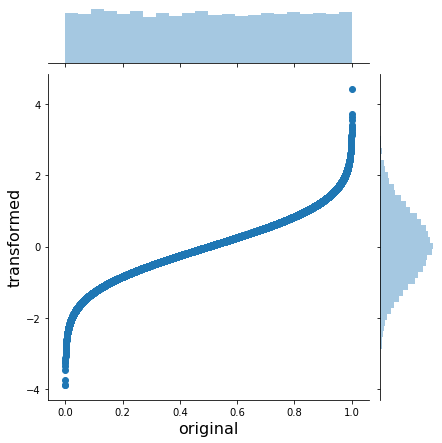

In [17]:
h = sns.jointplot(x, x_trans, stat_func=None)
h.set_axis_labels('original', 'transformed', fontsize=16);

Now, for the Beta distribution we have:

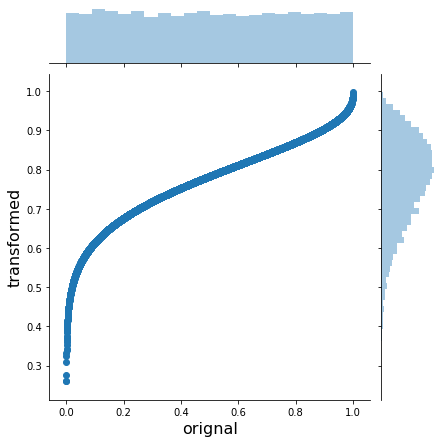

In [18]:
beta = stats.distributions.beta(a=10, b=3)
x_trans = beta.ppf(x)
h = sns.jointplot(x, x_trans, stat_func=None)
h.set_axis_labels('orignal', 'transformed', fontsize=16);

And now, in order to go back to the original distribution, we apply the inverse function

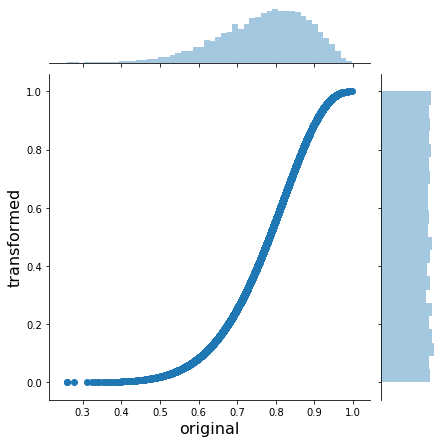

In [19]:
x_trans_trans = beta.cdf(x_trans)
h = sns.jointplot(x_trans, x_trans_trans, stat_func=None)
h.set_axis_labels('original', 'transformed', fontsize=16);

#### Adding correlation with Gaussian copulas
First: create samples from a correlated multivariate normal:

In [20]:
mvnorm = stats.multivariate_normal(mean=[0, 0], cov=[[1., 0.5], 
                                                     [0.5, 1.]])
# Generate random samples from multivariate normal with correlation .5
x = mvnorm.rvs(100000)

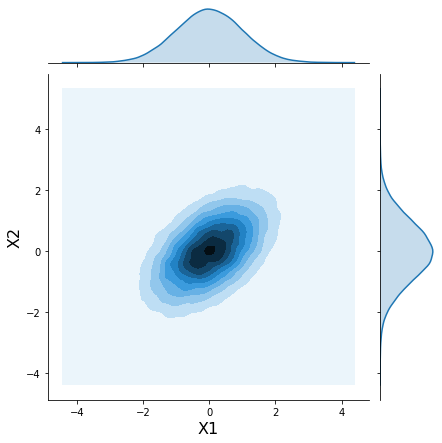

In [21]:
h = sns.jointplot(x[:, 0], x[:, 1], kind='kde', stat_func=None);
h.set_axis_labels('X1', 'X2', fontsize=16);

Now, we want to use the inverse function to create the uniform marginals of the copula

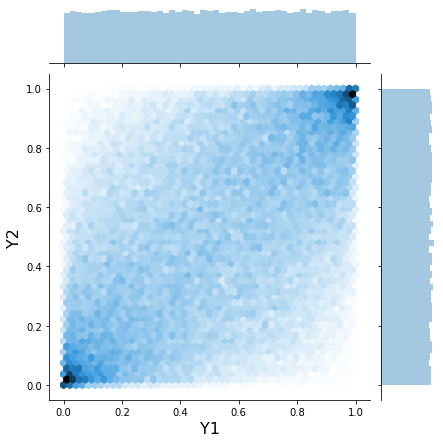

In [26]:
norm = stats.norm()
x_unif = norm.cdf(x)
h = sns.jointplot(x_unif[:, 0], x_unif[:, 1], kind='hex', stat_func=None)
h.set_axis_labels('Y1', 'Y2', fontsize=16);

Now that we added the correlation, we go back to the distributions beta and gumbel

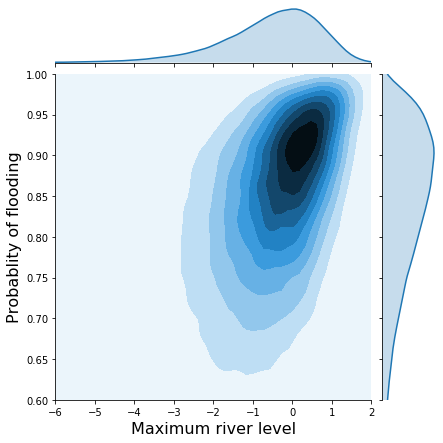

In [27]:
m1 = stats.gumbel_l()
m2 = stats.beta(a=10, b=2)

x1_trans = m1.ppf(x_unif[:, 0])
x2_trans = m2.ppf(x_unif[:, 1])

h = sns.jointplot(x1_trans, x2_trans, kind='kde', xlim=(-6, 2), ylim=(.6, 1.0), stat_func=None);
h.set_axis_labels('Maximum river level', 'Probablity of flooding', fontsize=16);

And here is the joint distribution without correlations

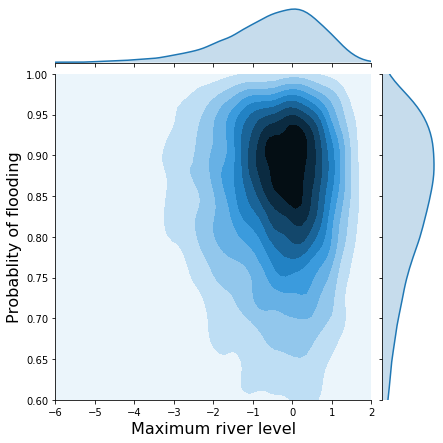

In [28]:
x1 = m1.rvs(10000)
x2 = m2.rvs(10000)

h = sns.jointplot(x1, x2, kind='kde', xlim=(-6, 2), ylim=(.6, 1.0), stat_func=None);
h.set_axis_labels('Maximum river level', 'Probablity of flooding',  fontsize=16);

In [69]:
from copulas.multivariate import GaussianMultivariate
copula = GaussianMultivariate()

In [22]:
# Formulación matemática
# Cómo se calcula la cópula de manera no paramétrica.
# ¿Sí se puedemejorar el rendimiento en tiempo?
# Añadir a Juan Carlos
# Artículo de derechos de autoría